## Nonparametric Models: kNN, Decision Trees and Local Regression

Last revision: Tue 22 Mar 2022 13:57:42 AEDT

Author: Omar Ghattas

## Introduction
In this lab we will look at nonparametric modelling, which is an alternative to parametric modelling that has been our focus in the last few weeks. We'll work through kNN, Linear Smoothing and Decision Trees in detail. We will implement these algorithms from scratch, and we'll also explore existing implementations in `sklearn`. We will also work with `Pandas` a bit more heavily to see how it can be used for data analysis.

## Nonparametric vs. Parametric Models
Surprisingly, it is difficult to have a good definition for nonparametric models and there is often disagreement about which models are nonparametric rather than parametric. Here we will try to build intuition for the differences between the two types of modelling regimes. First, let's recall our data generating process (DGP) set-up from tutorials, we assume that the data are generated independently according to the following process:

$$
y = f(x) + \epsilon,
$$

where $\epsilon$ is some random noise, and $f$ is the true data function that we wish to estimate. 

#### Parametric Modelling
In parametric modelling, we place a strong assumption on what kind of function $f$ really is, and we assume that this structure is known when we do our estimation. For example, in linear regression, we assume that $f(x) = w^T x$, i.e. that $f$ is a linear function parameterized by a vector $w$. We then proceed by estimating $w$ from the data. Parametric models tend to have a relatively small number of parameters. They are also usually high bias because of the strong assumptions placed on the underlying model. 

#### Nonparametric Modelling
In contrast to parametric models, here we place little to no assumptions on the underlying function $f$. Nonparametric models (the number of parameters) often grow as the size of the observed data grows.

#### Regression \& Classification
There are Nonparametric versions of both regression and classification models, and we will explore many of them throughout the course. Here is a short list to keep in mind:

Parametric:
1. Linear Regression
2. Ridge Regression
3. Lasso Regression
4. Perceptron (classification)
5. Logistic Regression (both regression and classification)

Nonparametric:
1. Decision Trees (both regression and classification)
2. k-Nearest Neighbours (kNN) (both regression and classification)
3. Local Linear Regression
4. Support Vector Machines (both regression and classification)
5. Random Forests (both regression and classification)

## kNN
We begin with the simplest nonparametric model, kNN, and we will explore both kNN classification and kNN regression. Both classification and regression variants require an understanding of the k-neighbour function: $\mathcal{N}_k(x)$. The $k$-neighbour function simply returns the $k$ points in the dataset that are nearest to the input $x$. We can define 'nearest' here quite broadly, and it is up to the modeler to come up with a distance function that they would like to use; the most common choice is the Euclidean distance $\|\cdot\|_2$.

#### Toy Regression Example
Let's assume we have data $X=[-1,0,1,2,3,4], y=[0.5,0.25,1,0.2, 0.8,3]$, and we choose $k=3$. Given an input point $x=0.25$, we have:

$$
\mathcal{N}_3(0.25) = \{ -1,0,1 \}.
$$

Now that we have identified the 3-NN of $x$, we need to return a prediction for it. The idea in kNN is just to use an average over the neighbours, so:

$$
\hat{y}(0.25) = \frac{1}{3} [0.5+ 0.25 +1 ] \approx 0.58
$$

is our prediction for this input. More rigorously, an average over the $k$-nearest neighbours can be written:

\begin{align*}
\hat{y}(x) 
&= \frac{1}{k} \sum_{i \in \mathcal{N}_k (x)} Y_i \\
&= \sum_{i=1}^n \frac{1}{k}\mathbf{1}\{\text{$X_i$ is a kNN of $x$} \} Y_i.
\end{align*}

#### Toy Classification Example
The kNN classifier works in the same was as kNN regression, except that instead of averaging, we take a majority vote of the class labels. This works for multi-class classification as well.

#### Note
The examples we showed here use numerical data, as in $X$ is comprised of numbers. However, kNN works whenever you have a way of measuring distance between objects. For example, if $X$ represented words in the alphabet that you were trying to classify into given classes, you could use kNN with Levenshtein (edit) distance.

In this lab we'll work with some of the same code used in Lab2 for sampling. For regression problems we'll simulate toy data from the model:

$$
y=f(x) + \epsilon, \qquad f(x) = 0.3 \cos(x) + 0.4 \ln(10x), \quad \epsilon \sim N(0,\sigma^2), \quad \sigma=0.5.
$$

The following code loads in the required packages and defines the `f_sampler` function used in Lab2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f_sampler(f, n=100, sigma=0.5, seed=123):    
    
    np.random.seed(seed)
    
    # sample points from function f with Gaussian noise (0,sigma**2)
    xvals = np.random.uniform(low=1, high=10, size=n)
    yvals = f(xvals) + sigma * np.random.normal(0,1,size=n)
    
    # build dataset D
    D = np.zeros(shape=(n, 2))
    D[:,0] = xvals; D[:,1] = yvals; 
    
    return D

<font color='purple'>
    
#### Exercise: 
In this exercise, we will write code to implement kNN regression from scratch. Generate data using the following code:

```
f = lambda x: 0.3 * np.cos(x) + 0.4 * np.log(10*x)
fsamples = f_sampler(f, 80, sigma=0.2, seed=120)
X = fsamples[:, 0]
y = fsamples[:, 1]
```

Write a function `kNNRegression(x, X, y, k)` that implements kNN regression (i.e., predicts a value for `x` where `x` is potentially an array of inputs based on data `X`, `y`) using $k$ neighbours and using euclidean distance. Run the algorithm with $k=1,\dots, 16$ and $p=2$ and plot each fit on a $4 \times 4$ grid plot, one plot for each $k$. Be sure to plot the original function and the samples on the same plot as well.

Hint: the function `np.argsort` might be useful here.
    

#### kNN with `sklearn`
Of course, `sklearn` has existing implementations of both kNN classification and kNN regression. These can be found by running:

```
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
```

Their usage follows the same standard `sklearn` approach we have seen in previous labs.

## Linear Smoothing
From the previous exercise, you will most likely notice that the fitted regression function using kNN is quite jagged, especially for smaller values of $k$. To understand this behaviour, it helps to look at the specific form of kNN predictions which we wrote down earlier:

\begin{align*}
\hat{y}(x) &= \sum_{i=1}^n \frac{1}{k}\mathbf{1}\{\text{$X_i$ is a kNN of $x$} \} Y_i.
\end{align*}

Note that this is of the form: $\hat{y}(x) = \sum_{i=1}^n w_i(x) Y_i$, so we can think of kNN as producing a weighted average of the responses $Y_i$, where the weights are chosen based on the given $x$. The 'weighting' scheme in kNN is rather crude; it looks at the closest $k$ elements and cuts out the rest, resulting in a jagged fit. We can improve the kNN regression model by incorporating other weight functions that will induce a smoother fit - this is the idea behind Linear smoothing, and we use special functions called kernels to define the weighting schemes. Specifically, we 
first define some common kernel functions:

1. Box-car Kernel: $K(u) = \mathbf{1} \{ |u| \le 1/2 \}$
2. Gaussian Kernel: $K(u) = \frac{1}{\sqrt{2 \pi}} \exp (-u^2/2)$ 
3. Epanechnikov Kernel: $K(u) = \frac{3}{4} (1-u^2) \mathbf{1} \{ |u| \le 1\}$

We then use a chosen kernel to construct a linear smoother which is defined by:

\begin{align*}
\hat{y}(x) 
&= \sum_{i=1}^n \frac{K \left (\frac{\| x - X_i \|_2}{h} \right )}{ \sum_{j=1}^n K \left (\frac{\| x - X_j \|_2}{h} \right ) } Y_i.
\end{align*}

In words, the $i$-th weight (the weight assigned to the $i$-th response $Y_i$) is the kernel function evaluated at the distance of $X_i$ from the input point $x$, and divided by a normalizing term to ensure that the weight add up to 1. The parameter $h$ is called the bandwidth, and plays a similar role as $k$ in kNN regression. Larger values of $h>0$ means we incorporate more information from points that are further away.

<font color='purple'>
    
#### Exercise: 
Implement the three kernels defined above.

<font color='purple'>
    
#### Exercise: 
Write a function `LinearSmoother(x, X, y, kernel, h)` that implements LinearSmoother using the data from the previous kNN regression exercise. Demonstrate your code by plotting your fitted functions for various bandwidth values and the three kernels defined above. Use the bandwidths `[0.8, 0.9, 1, 3]` for the boxcar kernel, `[0.5, 0.8, 1, 3]` for the Epanechnikov kernel and `[0.4, 0.5, 1, 5]` for the Gaussian kernel. What do you notice happens to the fits as you vary the bandwidth?

#### Existing Implementations
Unfortunately, there are no `sklearn` implementations of the linear smoother, however a good implementation does exist in `scipy.statsmodels.nonparametric.kernel_regression`, (kernel regression, Nadaraya-Watson) are two different names commonly used for linear smoothing. You can read more about it here:

https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.kernel_regression.KernelReg.html

## The curse of dimensionality
The algorithms we have seen so far (kNN and Linear Smoothing) are quite straight forward to construct, even more so than the parametric models we have dealt with in the past. One problem that arises however is the curse of dimensionality, which is a problem that plagues much of nonparametric modelling. The problem is the following: distances break down in high dimensional spaces.

What this means is that when we are dealing with high dimensional data (such as MNIST), the distances between objects in high dimensional space are not very informative. So an image with class label '0' will have similar distance to an image with class label '8' as it does to other images in class '0'. Since kNN and LS rely on finding neighbouring points, their performance is affected negatively, to the point that they become useless.

We can demonstrate this breakdown of distances through the following simulation experiment:

The set $[0,1]^d$ consits of $d$-dimensional vectors with elements between 0 and 1 and is called the $d$-dimensional unit cube. We can generate $n$ independent samples uniformly distributed on $[0,1]^d$ using the code: `np.random.random(low=0.0, high=1.0, size=(n,d))`.

The idea will be to sample $n=1000$ points on $[0,1]^d$, and increase $d$ from $d=1$ to $d=784$. For each $d$, we will compute the pairwise Euclidean distances between the $n$ points and plot a histogram. As the dimension increases, we will see that the distribution of the distances becomes more and more concentrated. This is bad because it means that all the points have similar distance to each other, and so we cannot really figure out different labels for these points.

Note: that the 2-norm has min value zero, and max value $\sqrt{2}$, so for dimension 2, the maximum 2-norm is  $\sqrt{d}$, for dim=100, the maximum is $10$, etc, which is why the x-axis range changes from plot to plot.


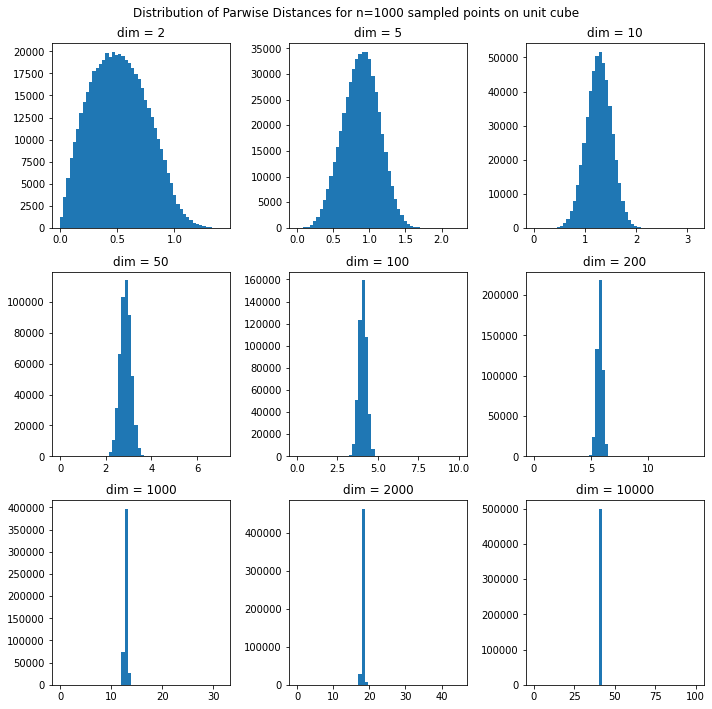

In [5]:
n = 1000
dims = [2, 5, 10, 50, 100, 200, 1000, 2000, 10000]
fig, axs = plt.subplots(3,3, figsize=(10,10))
for i, ax in enumerate(axs.flat):
    d = dims[i]
    
    # randomly sample N points from [0,1]^dim
    X = np.random.uniform(low=0., high=1., size=(n, d))
    
    # compute pairwise distances between the points
    pdists = np.array([np.linalg.norm(X[i]-X[j], ord=2) for i in range(n) for j in range (i+1, n)])
    
    # plot histogram
    ax.hist(pdists, range=[0, np.sqrt(d)], bins=50)  
    ax.set_title(f"dim = {d}")
plt.suptitle(f"Distribution of Parwise Distances for n={n} sampled points on unit cube")
plt.tight_layout()

## Decision Trees for Classification
An important nonparametric model is the decision tree, which is the building block for more complex models such as the random forest and adaptive boosting algorithms we will encounter later on in the course. Decision trees can be thought of as a large set of `if-then-else` statements. They are also referred to as recursive partitioning algorithms, since they repeatedly partition the input space into smaller and smaller subsets or regions. In this section we will focus on decision trees for classification, but note that they are also able to be used for regression problems.

#### Recursive Partitioning and visualizing classifiers
We first aim to understand decision trees as a partitioning estimator. To do so, we'll need the following helper function that allows us to visualize the classifier, and you can use it as a black box for the remainder of the lab.

In [8]:
# Helper function for visualising classifiers and decision surfaces    
def visualize_classifier(model, X, y, ax=None, cmap='rainbow', title=None):
    
    # reference: Python Data Science Handbook by Jake VanderPlas
    ax = ax or plt.gca()
    
    # Plot the training points
    
    if np.any(y==-1):
        y[y==-1] = 0.   # fix to get scatter c=y arg working when we use -1,1 coding
    
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
                        clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # compute predictions on grid
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    if np.any(Z==-1):     # fix to get c=y working
        Z[Z==-1] = 0

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    if title:
        ax.set_title(title)

The `sklearn.datasets.make_blobs` function gives us a quick way to create toy data for classification. In the following we'll create a 3 class classification problem 

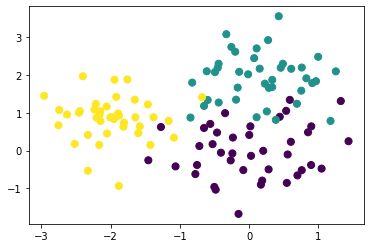

In [9]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=120,                           # total number of samples  
                  centers=[[0,0], [0,2], [-2,1]],          # cluster centers of the 3 classes
                  random_state=123,                        # reproducibility 
                  cluster_std=0.6)                         # how spread out are the samples from their center
                 
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)                   # scatter with color=label
plt.show()

We will also use the `sklearn.neighbors.KNeighborsClassifier` and `sklearn.tree.DecisionTreeClassifier` objects to demonstrate the `visualize_classifier` function. The shaded regions correspond to how the classifier would classify a point that falls in that region. Note that for the kNN classifier, the regions are quite jagged, whereas the regions for the DT are always constructed by splitting using straight lines.

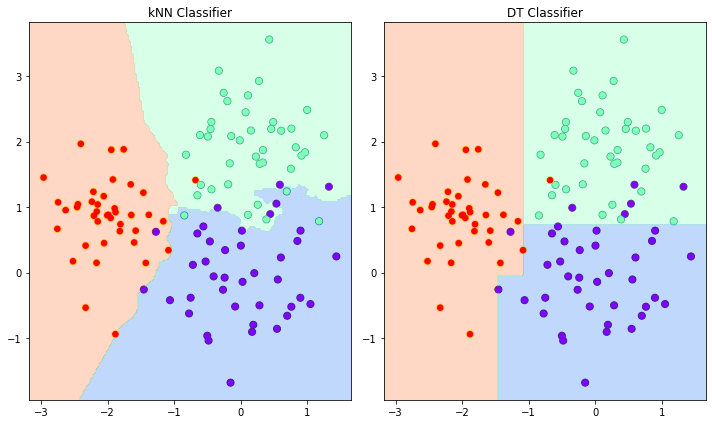

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# kNN with 5 neighbours and euclidean distance (p=2)
model0 = KNeighborsClassifier(n_neighbors=5, p=2)   

# DT with max depth of 3 and entropy criterion (this is information gain from lectures/tutorials)
model1 = DecisionTreeClassifier(max_depth=3, criterion='entropy', random_state=3)     

# fit both models
model0.fit(X,y)
model1.fit(X,y)


# visualize classifiers
fig, axes = plt.subplots(1,2, figsize=(10,6))

# scatter data
axes[0].scatter(X[:, 0], X[:, 1], c=y, s=50)
axes[1].scatter(X[:, 0], X[:, 1], c=y, s=50)

# classifier plot
visualize_classifier(model0, X, y, ax=axes[0], title="kNN Classifier")
visualize_classifier(model1, X, y, ax=axes[1], title="DT Classifier")

plt.tight_layout()
plt.show()


Another good way to visualize a tree is to look directly at the rules it uses to perform the splits at each depth. Recall that for a classification decision tree, we pass an input down the tree and look at the majority class in the child node that it falls into to find its predicted class. In regression, we do something identical, except that instead of taking a majority, we can use an average (or weighted average) of the points in the child node (similar to kNN regression)

Note that the color of the labels correspond to the majority class at that particular point. The plot also gives us the distribution of the three classes at each node (`value`), and tells us the number of samples that falls into a particular node. We also can see the information gain (`entropy`) (see tutorials for details) for each node.

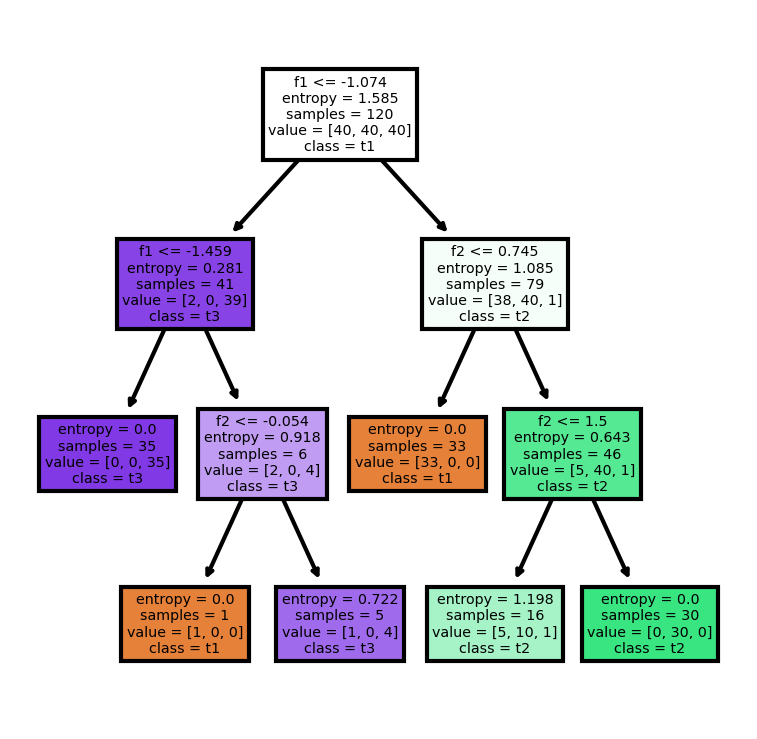

In [20]:
from sklearn import tree

fig, axes = plt.subplots(1, 1,figsize = (3,3), dpi=300)
tree.plot_tree(model1,                                      # fitted decision tree
               feature_names=['f1', 'f2'],                  # some names for the features
               class_names=['t1', 't2', 't3'],              # some names for the class labels
               filled=True)
plt.show()

<font color='purple'>
    
#### Exercise: 
Generate data using the following code:
    
```
X, y = make_blobs(n_samples=500,              
              centers=[[0,0], [0,2], [-2,1], [-2,2], [3,3], [1,-2]], 
              random_state=123, 
              cluster_std=0.6)  
```
Then fit a decision tree (using information gain for splits) with `max_depth` set to $1,2,\dots, 12$ and visualize the classifier (use a $3 \times 4$ grid). What do you observe? Why do you think decision trees are described as performing 'recursive partitioning'?

<font color='purple'>

#### Extended Data Exercise
In this exercise, we'll work with the `titanic.csv` dataset which you should have available in the same working directory where this notebook is located. If you get stuck at any point, the first thing to do will be to google your question - when it comes to data analysis in Python it is almost impossible to remember all the different commands, and https://stackoverflow.com/ is your best friend.
    
1. Using `pandas`, load in the dataset and call the dataframe `df`. Run `df.info()` to gain an understanding of the different features.

2. Remove the following columns `'PassengerId','Name', 'Ticket','Cabin', 'Embarked'` from the data, as we won't be using them for this exercise.
    
3. Use the `dropna()` method to remove any missing rows.
    
    
4. We would like to treat all attributes as numeric, so convert the `Sex` feature to numeric, and code males as 0 and females as 1. Hint: a good approach is to use the `df.Sex.map()` method.
    
5. We will be interested in predicting `Survived` as a function of the remaining features. Create `X,y` `numPy` arrays to use for this problem. Be sure to also save a copy of the names of the columns. Hint: use `iloc` to index pandas dataframes, and use `to_numpy()` to convert pandas dataframes to numpy arrays.
    
6. Create train/test datasets using 70\% of your data for training.
    
7. Fit decision trees to your training dataset: do this for `max_depth`=1,...,20. For each depth, record the train and test classification error (1-accuracy). Create a plot of error against depth, and plot both the train and test errors. What do you notice?
    
8. Re-fit the model on the entire dataset with a depth 3 tree. Plot the decision tree and interpret the results.